In [1]:
#
# This section taken from MaterialsAutomated4-DIFFaXPython
#

#
# Runs the external program (DIFFaX) with the given input
# string as the input data file. Collects all possible
# DIFFaX outputs, returning a dictionary with the results,
# or raising an exception with a non-zero return code.
# All results are the raw outputs, except 'spc', which is
# parsed as the tab separated value file it is, and returned
# as a list of lists.
#
import subprocess
import os
import csv
from pathlib import Path
def runDIFFaXExt(inpdat, thmin=5.0, thmax=60.0, thstep=0.01, prefix="/tmp/DIFFaX", diffax_dir=Path(os.getcwd(),"DIFFaX_1813")):
    with open(prefix + ".inp","w") as f:
        f.write(inpdat)
    # DIFFaX doesnt overwrite files, so we need to
    # remove the output files before running this
    # instance of DIFFaX. We wrap in try blocks
    # in case files do not exist
    try:
        os.remove(prefix + ".spc")
    except FileNotFoundError:
        pass
    try:
        os.remove(prefix + ".dmp")
    except FileNotFoundError:
        pass
    try:
        os.remove(prefix + ".sym")
    except FileNotFoundError:
        pass
    #
    # We collect all verbose outputs (.dmp, .sym, .spc)
    #
    inp = """{ipf}
1
1
1
3
{thmin} {thmax} {thstep}
1
1
""".format(ipf=prefix+".inp",thmin=thmin,thmax=thmax,thstep=thstep)
    runans = subprocess.run([str(Path(diffax_dir,"DIFFaX"))], input=inp.encode("utf-8"), cwd=str(diffax_dir), capture_output=True, check=True)
    rv = {'inp': None, 'spc': None, 'dmp': None, 'sym': None, 'stdout': runans.stdout, 'stderr': runans.stderr}
    for k in rv.keys():
        try:
            if k == 'spc':
                with open(prefix + "." + k, "r", newline='') as f:
                    arr = []
                    opf = csv.reader(f, delimiter='\t')
                    for r in opf:
                        arr.append(r)
                    rv[k] = arr
            else:
                with open(prefix + "." + k, "r") as f:
                    rv[k] = f.read()
        except FileNotFoundError:
            pass
    return rv

#
# This function constructs and executes a DIFFaX run for
# a given crystallographic input and ancillary parameters.
# For compatibility with a range of actual python structure
# implementations, expects inputs in a semi-processed form.
# Parameters:
# a,b,c = lattice parameters in angstroms, with "c" being the stacking axis
#         (perpendicular to a and b).
# gamma = angle between a and b.
# layers = list, containing atom info for each layer
# trans[i][j] = list of lists specifying the
#               transition probability and vector
#               for each i-j pair as a 4-tuple (prob,dx,dy,dz)
#               prob as a fraction, dx,dy,dz as fractions of a,b,c
# Each individual layer in layers is a list of tuples, containing:
#  (sym, x, y, z, Biso, occ)
# where sym is the atomic symbol, x,y,z are fractional coordinates, Biso
# is the thermal parameter, and occ is the occupancy. No symmetry is
# assumed in any layer, so *all* atoms must be included.
# If it is *not* the first layer, than this can also specify the index
# of the equivalent layer. That means:
#   layers[0] = [...]
#   layers[1] = 0
# would define layer 2 (=1) as the same as layer 1 (=0)
# Optional parameters:
# rad = radiation type (X-RAY | NEUTRON | ELECTRON)
# lam = wavelength in angstrom
# peak = peak broadening type (NONE | GAUSSIAN | LORENTZIAN | PSEUDO-VOIGT)
# gu, gv, gw = gaussian/lorentzian/pseudo-voigt u, v, w values
# gs = pseudo-voigt sigma value
# **kwargs = extra arguments to pass to runDIFFaXExt
#
def runDIFFaX(a, b, c, gamma, layers, trans, rad="X-RAY",lam=1.5418, peak="GAUSSIAN", gu=0.1, gv=-0.036, gw=0.009, gs=0.01, **kwargs):
    abcga = "{a:.6f} {b:.6f} {c:.6f} {g:.3f}".format(a=a,b=b,c=c,g=gamma)
    peakparam = ""
    if peak.upper() == "GAUSSIAN" or peak.upper() == "LORENTZIAN":
        peakparam = "{gu:.5f} {gv:.5f} {gw:.5f}".format(gu=gu,gv=gv,gw=gw)
    elif peak.upper() == "PSEUDO-VOIGT":
        peakparam = "{gu:.5f} {gv:.5f} {gw:.5f} {gs:.5f}".format(gu=gu,gv=gv,gw=gw,gs=gs)
    inpdat = """INSTRUMENTAL
{rad}
{lam:.6f}
{peak} {peakparam}
STRUCTURAL
{abcga}
UNKNOWN
{nl}""".format(rad=rad,lam=lam,peak=peak,peakparam=peakparam,gu=gu,gv=gv,gw=gw,abcga=abcga,nl=len(layers))
    l = 1
    for layer in layers:
        if isinstance(layer,int):
            inpdat += "\nLAYER {lnum} = 1".format(lnum=l)
        else:
            inpdat += "\nLAYER {lnum}\nNONE".format(lnum=l)
            n = 1
            for r in layer:
                inpdat += "\n{sym:4s} {n} {x:.6f} {y:.6f} {z:.6f} {Biso:.3f} {occ:.4f}".format(sym=r[0],n=n,x=r[1],y=r[2],z=r[3],Biso=r[4],occ=r[5])
                n += 1
        l += 1
    inpdat += """\nSTACKING
recursive
infinite
TRANSITIONS"""
    for i in range(0,len(trans)):
        for j in range(0,len(trans[i])):
            inpdat += "\n{prob} {dx:.6f} {dy:.6f} {dz:.6f}".format(prob=trans[i][j][0],dx=trans[i][j][1],dy=trans[i][j][2],dz=trans[i][j][3])
    return runDIFFaXExt(inpdat, **kwargs)


In [2]:
#
# This function utilizes SciPy's curve_fit functionality to find
# a set of parameters that best models input data (2-Theta,Intensity),
# using DIFFaX as the simulation backend. It requires defining and
# passing as inputs five functions:
#  get_background(xdata,*args): given a set of x points and the refinable
#   parameters (args), returns the ydata contributions for the backgound.
#   For maximum flexibility, is not multiplied by the overall scale factor.
#   A "no background" function would be lambda xdata,*args: np.zeros(xdata.shape)
#  get_inst(*args): given the refinable parameters (args), returns a
#   dictionary containing key=>value pairs for instrument values suitable
#   for passing into runDIFFaX. A "no special params" function would
#   be: lambda *args: {}
#  get_abcga(*args): given the refinable parameters (args), returns a list
#   containing the a,b,c, and gamma parameters. A "fixed lattice" function
#   would be: lambda *args: [a,b,c,gamma]
#  get_layers(*args): given the refinable parameters (args), returns a list
#   containing the layers (see runDIFFaX specification)
#  get_trans(*args): given the refinable parameters (args), returns a list
#   containing the transitions (see runDIFFaX specification)
# In addition, the other required inputs are the data to fit: xdata,ydata,
# in scipy.optimize.curve_fit format, and p0, a list containing initial
# guesses for all refinable parameters (except an overall scale factor, which
# this function adds transparently). kwargs can be used to pass other keyword
# arguments (e.g. bounds, etc, transparently to curve_fit).
#
# It sets a default tolerance for parameters (xtol) of 0.3%, much looser than
# the curve_fit default. It works well for most problems, but if higher precision
# results are needed, specify a smaller value of xtol.
#
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import numpy as np
def runDIFFaXOpt(xdata,ydata,get_background,get_inst,get_abcga,get_layers,get_trans,p0,**kwargs):
    if not ('xtol' in kwargs):
        kwargs['xtol'] = 0.003
    if not ('diff_step' in kwargs):
        kwargs['diff_step'] = 1e-6
    if 'bounds' in kwargs:
        lb = kwargs['bounds'][0]
        ub = kwargs['bounds'][1]
    else:
        lb = None
        ub = None
    if lb is None:
        lb = -np.inf
    if ub is None:
        ub = np.inf
    if isinstance(lb, (int, float, complex)) and not isinstance(lb, bool):
        lb = [lb for x in range(0,len(p0))]
    if isinstance(ub, (int, float, complex)) and not isinstance(ub, bool):
        ub = [ub for x in range(0,len(p0))]
    lb = [0.0] + list(lb)
    ub = [np.inf] + list(ub)
    kwargs['bounds'] = (lb,ub)
    def opt_f(x, osf, *args):
        thstep = np.amin(np.diff(x))
        thmin = np.amin(x)
        thmax = np.amax(x)
        drv = runDIFFaX(*get_abcga(*args),get_layers(*args),get_trans(*args),thmin=thmin,thmax=thmax,thstep=thstep,**get_inst(*args))
        irv = np.array(drv['spc'],dtype=np.float64)
        irv = interp1d(irv[:,0],irv[:,2])
        return osf*irv(x)+get_background(x,*args)
    rv = list(curve_fit(opt_f,xdata,ydata,p0=[1.0]+p0,**kwargs))
    rv.append(opt_f(xdata,*rv[0]))
    return rv

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.1734e+02                                    1.09e+04    
       1              2         1.3077e+02      4.87e+02       2.05e-01       2.28e+03    
       2              3         4.3272e+01      8.75e+01       6.13e-02       5.87e+02    
       3              4         1.0588e+01      3.27e+01       1.38e-01       2.27e+02    
       4              5         1.7560e+00      8.83e+00       7.23e-02       7.62e+01    
       5              6         4.3489e-01      1.32e+00       2.33e-02       3.95e+01    
       6              7         1.0984e-01      3.25e-01       1.29e-02       2.14e+01    
       7              8         3.2949e-02      7.69e-02       4.98e-03       1.16e+01    
       8              9         9.1581e-03      2.38e-02       2.93e-03       6.82e+00    
`xtol` termination condition is satisfied.
Function evaluations 9, initial cost 6.1734e+02

<IPython.core.display.Javascript object>


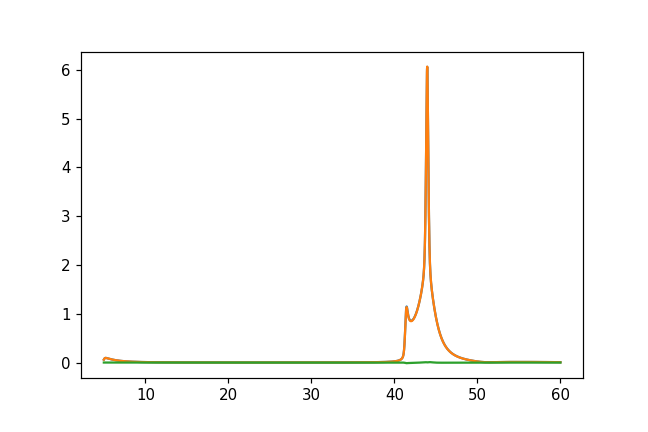

In [3]:
#
# Run DIFFaX on the example/sample input file, to 
# generate "practice" data to fit using our routines.
#
finp = """INSTRUMENTAL
X-RAY
1.5418
PSEUDO-VOIGT .89 -.32 .08 .6 trim
STRUCTURAL
2.52 2.52 2.06 120
6/MMM
2
LAYER 1
CENTROSYMMETRIC
C   1 -1/3 -1/6 -1/8 1 1
LAYER 2
CENTROSYMMETRIC
C   1 1/3 1/6 -1/8 1 1
STACKING
recursive
infinite
TRANSITIONS
.7 2/3 1/3 1
.3 0 0 1
.3 0 0 1
.7 -2/3 -1/3 1
"""
rv = runDIFFaXExt(finp)
#
# Try to recover two parameters (scale factor, stacking fault fraction)
# from the "practice" data. The output values should be close to "1.00"
# and "0.700", with good agreement between "data" (blue), "model" (orange),
# and difference (green).
#
pred = np.array(rv['spc'],dtype=np.float64)
xd = pred[:,0]
yd = pred[:,2]
def get_layers(*args):
    return [[('C',-0.3333333333,-0.1666666667,-0.125,1.0,1.0),('C',0.3333333333,0.1666666667,0.125,1.0,1.0)],[('C',0.3333333333,0.1666666667,-0.125,1.0,1.0),('C',-0.3333333333,-0.1666666667,0.125,1.0,1.0)]]
def get_trans(tp,*args):
    return [[(tp,0.666666667,0.33333333,1),(1-tp,0,0,1)],[(1-tp,0,0,1),(tp,-0.666666666667,-0.333333333333,1)]]
rv = runDIFFaXOpt(xd,yd,lambda xdata,*args: np.zeros(xdata.shape),lambda *args: {'peak':"PSEUDO-VOIGT",'gu':0.89,'gv':-0.32,'gw':0.08,'gs':0.6},lambda *args: [2.52,2.52,2.06,120],get_layers,get_trans,[0.95],bounds=(0.0,1.0),verbose=2)
print(rv[0])
#
# Plot original and recovery
#
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
yd2 = rv[2]
print(np.sum((yd2-yd)*(yd2-yd),axis=0))
plt.plot(xd,yd)
plt.plot(xd,yd2)
plt.plot(xd,yd2-yd)

In [4]:
#
# The cells after this point go through using the tool to conduct a
# fit of "real" data. This includes reading a structure from a CIF
# file, visualizing the extracted layer (in this case, a pair of
# layers forms a single layer from a DIFFaX sense) to ensure it
# is as desired, defining appropriate functions to refine only a
# stacking fault fraction and a coherent / constrained motion of
# all Nb atoms in the sample structure, with all other atoms frozen
# in place. This is then readily adapted to any arbitrary problem
# of scientific interest.
#

In [5]:
#
# Use ASE to read the cif file for Nb3Cl8, which contains
# two individual layers that, together, form a pair of layers
# that is used as a single DIFFaX layer.
# The warning on import is due to a (benign) error in the input file.
#
import ase.io
nb3cl8 = ase.io.read('Nb3Cl8_300K.cif')
abcalbega = nb3cl8.get_cell_lengths_and_angles()
#
# Here we define the functions with refinable parameters as
# arugments. We have four refinable parameters in this model:
# 1. tp = transition probability of R-3m stacking
# 2. dnbx,dnby,dnbz = shifts of Nb x,y,z coordinates.
# Because these are not passed as named/keyword arguments,
# it is important to expect all parameters to be in the
# same order for all functions, but for simplicity one can
# "ignore" all parameters after the one needed by a particular
# function by ending with *args.
#
def get_abcga(*args):
    return [abcalbega[0],abcalbega[1],abcalbega[2],abcalbega[5]]
#
# Two DIFFaX layers that are in fact identical. This allows for variability
# in stacking between individual layers with otherwise identical layers. Here
# we compute the content of each layer starting with the coordinates loaded
# from the cif (nb3cl8) and applying the dnbx,y,z shifts to the Nb atoms.
#
def get_layers(tp,dnbx,dnby,dnbz,*args):
    layer1 = []
    for sym,xyz in zip(nb3cl8.get_chemical_symbols(),nb3cl8.get_scaled_positions()):
        if sym == 'Nb':
            layer1.append((sym,xyz[0]+dnbx,xyz[1]+dnby,xyz[2]+dnbz,1.0,1.0))
        else:
            layer1.append((sym,xyz[0],xyz[1],xyz[2],1.0,1.0))
    return [layer1, 0]
#
# Transition probabilities enabling inclusion of a tp fraction of 2/3,1/3,1 transitions,
# corresponding to R-3m-type stacking, and a 1-tp fraction of 0,0,1 transitions,
# corresponding to P-3m-type stacking.
#
def get_trans(tp,*args):
    return [[(tp,0.66666666666666667,0.333333333333333333,1),(1-tp,0,0,1)],[(1-tp,0,0,1),(tp,0.66666666666666667,0.333333333333333333,1)]]


/home/idies/miniconda3/envs/py37/lib/python3.7/site-packages/ase/io/cif.py:375: UserWarning: crystal system 'monoclinic' is not interpreted for space group Spacegroup(164, setting=1). This may result in wrong setting!
  setting_name, spacegroup))


In [6]:
#
# Here we visualize the input layer structure, while demonstrating some of the ASE
# capabilities for slicing and dicing bulk structures. Specifically, we extract each of
# the two individual Nb3Cl8 layers within a unit cell as individual slabs:
# the first half of the unit cell and the second half of the unit cell
# (along the c axis). We then reconstruct the full unit cell using ASEs stack functionality
# and vitualize the result. This is a "no-op" for visualizing the input (nb3cl8 could be
# plotted directly), but demonstrating layer building that will be useful in some
# instances.
#
import ase.build
nb3cl8slab = ase.build.cut(nb3cl8,c=(0,0,0.5))
nb3cl8slab2 = ase.build.cut(nb3cl8,c=(0,0,0.5),origo=(0,0,0.5))
from ase_notebook import AseView, ViewConfig
config = ViewConfig()
ase_view = AseView(config)
ase_view.config.atom_show_label = True
ase_view.config.canvas_background_opacity = 0.0
ase_view.config.rotations = "45x,45y,45z"
svg = ase_view.make_render(ase.build.stack(nb3cl8slab,nb3cl8slab2), center_in_uc=True)
svg

GridspecLayout(children=(Renderer(camera=PerspectiveCamera(fov=10.0, position=(0.0, 0.0, 113.58394403234087), …

In [7]:
#
# Read the data we are going to fit
#
import csv
with open('Nb3Cl8-Faulted.csv', 'r', newline='') as file:
    reader = csv.reader(file,delimiter=',')
    arr = []
    for x,y in reader:
        arr.append([x,y])
arr = np.array(arr,dtype=np.float64)
xd = arr[:,0]
yd = arr[:,1]

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3259e+12                                    1.78e+13    
       1              2         3.1498e+11      1.01e+12       2.49e-01       3.91e+12    
       2              3         9.8712e+10      2.16e+11       9.22e-02       9.88e+11    
       3              4         1.7206e+10      8.15e+10       8.42e-02       3.42e+11    
       4              5         5.9269e+09      1.13e+10       4.56e-02       2.01e+11    
       5              6         1.8280e+09      4.10e+09       2.62e-02       6.38e+10    
       6              7         5.9046e+08      1.24e+09       1.58e-02       3.84e+10    
       7              8         2.3255e+08      3.58e+08       1.30e-02       1.80e+10    
       8              9         6.4218e+07      1.68e+08       5.24e-03       8.75e+09    
       9             10         2.3680e+07      4.05e+07       3.50e-03       4.48e+09    

<IPython.core.display.Javascript object>


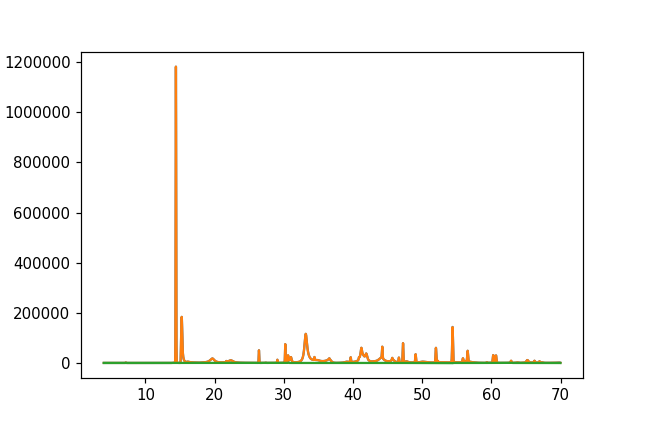

In [8]:
#
# Do the fit, and print the results. The p0 initial guesses must be
# in the same order as the get_ functions above: tp,dnbx,dnby,dnbz
# We take advantage of periodicity of the scaled coordinates, and
# constrain dnbx,dnby,dnbz to be in the range [-0.5,0.5]. The
# transition probability must be in the range [0.0,1.0]. The
# result should be close to:
# [0.78006673 0.7004017  0.02162346 0.02223893 0.01002365]
# [scale fact tp         dnbx       dnby       dnbz]
#
rv = runDIFFaXOpt(xd,yd,lambda xdata,*args: np.zeros(xdata.shape),lambda *args: {},get_abcga,get_layers,get_trans,[0.95,0.001,0.001,0.001],bounds=((0.0,-0.5,-0.5,-0.5),(1.0,0.5,0.5,0.5)),verbose=2)
print(rv[0])
#
# Plot data and best fit
#
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
yd2 = rv[2]
plt.plot(xd,yd)
plt.plot(xd,yd2)
plt.plot(xd,yd2-yd)